# K-Means clustering

Please read the comments in each code block. The comments provide instructions and there are places that you are expected to fill in your own code. In order to get familiar with scikit learn's library you are expected to read the documentation. In the comments for the code links have been provided.

If you have followed [my instructions](http://user.it.uu.se/~justin/Hugo/post/python_notebooks_ml/) on setting up virtual environments, then you might not have skimiage or tqdm installed. You need to install the following packages
```
pip install scikit-image
pip install tqdm
```

In [292]:
# import stuff that we need
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import skimage.io as skio
import tqdm as tq
from tqdm import tqdm_notebook as tqdm

We will work a particular image taken from Wikipedia. It is included in the repository as `talos.jpg`. The orginal can be downloaded from [wikimeda](https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Vaso_di_Talos_particolare.JPG/1920px-Vaso_di_Talos_particolare.JPG) be sure to save it as `talos.jpg`.


# Part 1 - K-Means clustering

K-means clustering is an unsupervised method for finding clusters in data. There can be any amount of clusters and there can by any dimensions. Let's name the number of clusters K, and the number of dimensions D.
The algorithm works as:

1. Specify the number of clusters *k*
2. Randomly initialize *k* centroids in the data. 
3. Assign each point to its closest centroid
4. Compute the new centroids (mean) of each cluster
5. Repeat 3 and 4 until cluster centers does not change or until a pre-defined number of iterations


One special case of K-means is image compression, this will be the topic of this notebook.

Let's start with an image. Load the image and standardize it, i.e scale the values to a range 0-1.

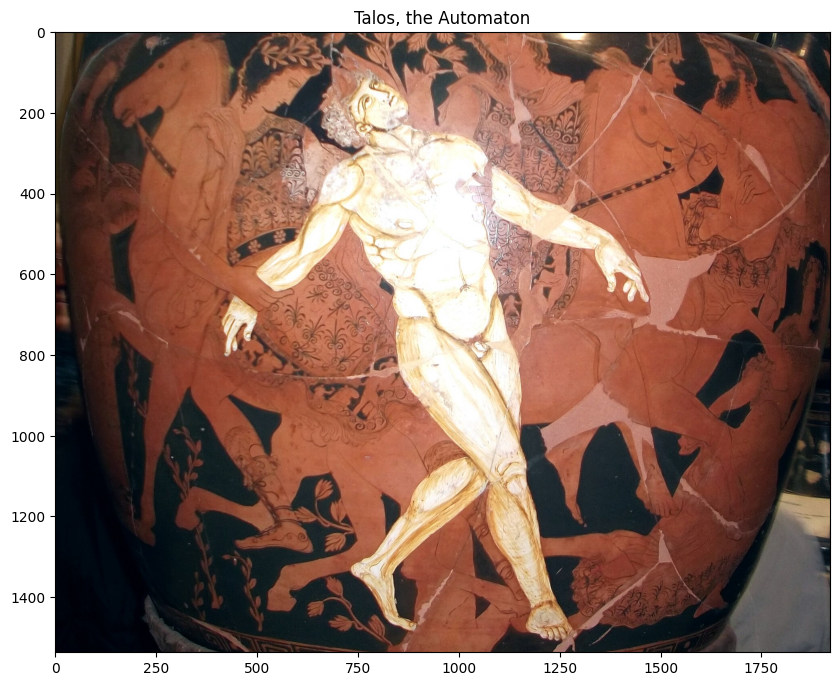

In [293]:
# Loading the image
# Documentation: https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread
image = skio.imread("talos.jpg")



# Standardization of the image (values go from the range 0-255 to 0-1)
# Documentation: https://scikit-image.org/docs/dev/api/skimage.html#skimage.img_as_float32
image = skimage.img_as_float32(image)

assert image.max() - 1.0 < 1e-7, "The image must be standardized."

# Plotting the image
plt.figure(figsize=(10, 10))
plt.title("Talos, the Automaton")
plt.imshow(image)
plt.show()

In [294]:
print(f"Image width   : {image.shape[0]}")
print(f"Image height  : {image.shape[1]}")
print(f"Image channels: {image.shape[2]}")
print(f"Image size    : {np.prod(image.shape)}")

Image width   : 1537
Image height  : 1920
Image channels: 3
Image size    : 8853120


### Image Information:
- **Width**: 1537 pixels
- **Height**: 1920 pixels
- **Channels**: RGB (Red, Green, Blue)
- **Uncompressed Size Calculation**: 
    - Total pixels = Width × Height = 1537 × 1920 = 2,956,160 pixels
    - Each pixel has 3 channels (RGB), so the total number of values = 2,956,160 × 3 = 8,868,480 values
    - Each value is coded as a byte (8 bits), so the full uncompressed image size = 8,868,480 bytes or approximately 8.9 MB (megabytes).

### Color Depth and Compression:
- **Current Color Depth**: Each channel uses 8 bits, resulting in 24 bits per pixel (8 bits for Red, 8 for Green, and 8 for Blue). This allows for 2^24(around 16 milion) different colors.
- **Reducing Colors for Compression**: 
    - By choosing a palette with K colors (e.g., 16), the image would be restricted to only 16 different colors.
    - With a palette of 16 colors, each pixel can be represented using 4 bits (as 2^4 = 16). This is significantly smaller compared to the original 24 bits per pixel.
- **Compression Factor**: 
    - Reducing from 24 bits (RGB) to 4 bits (with a palette of 16 colors) results in a compression factor of 83%.
    - The reduction in bits per pixel leads to a smaller file size while sacrificing some color fidelity.

But first, let's reshape the data to be able to display the RGB data in 3-dimensions and discard some data for faster computations.

In [295]:
# This steps reshape the image in the format (N, D) for N points in D dimensions.
# D will always be 3 since we will only deal with RGB images today.
pixels = image.reshape(-1, 3)
print("Pixels array shape                   :", pixels.shape)

# There are 2 951 040 pixels in 3 dimensions, which is A LOT!
# If you have too much data, algorithms will be slow, and displaying the data can take forever (literally).
# So let's keep 0.1% of them (in other words randomly discard 99.9%)
# Documentation: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html


keep = np.random.rand(pixels.shape[0])<0.001

assert keep.dtype == bool, "keep must be containing booleans"
assert len(keep) == pixels.shape[0], "keep has the wrong shape, it should be pixels.shape[0]"
assert (np.unique(keep) == [False, True]).all(), "keep must only contain True/False values"
# Now the smaller dataset is named pixels_small
pixels_small = pixels[keep]
print("Pixels array shape (after discarding):", pixels_small.shape)
print(f"Reduction in size                    : {1-pixels_small.shape[0]/pixels.shape[0]:.1%}")

Pixels array shape                   : (2951040, 3)
Pixels array shape (after discarding): (3019, 3)
Reduction in size                    : 99.9%


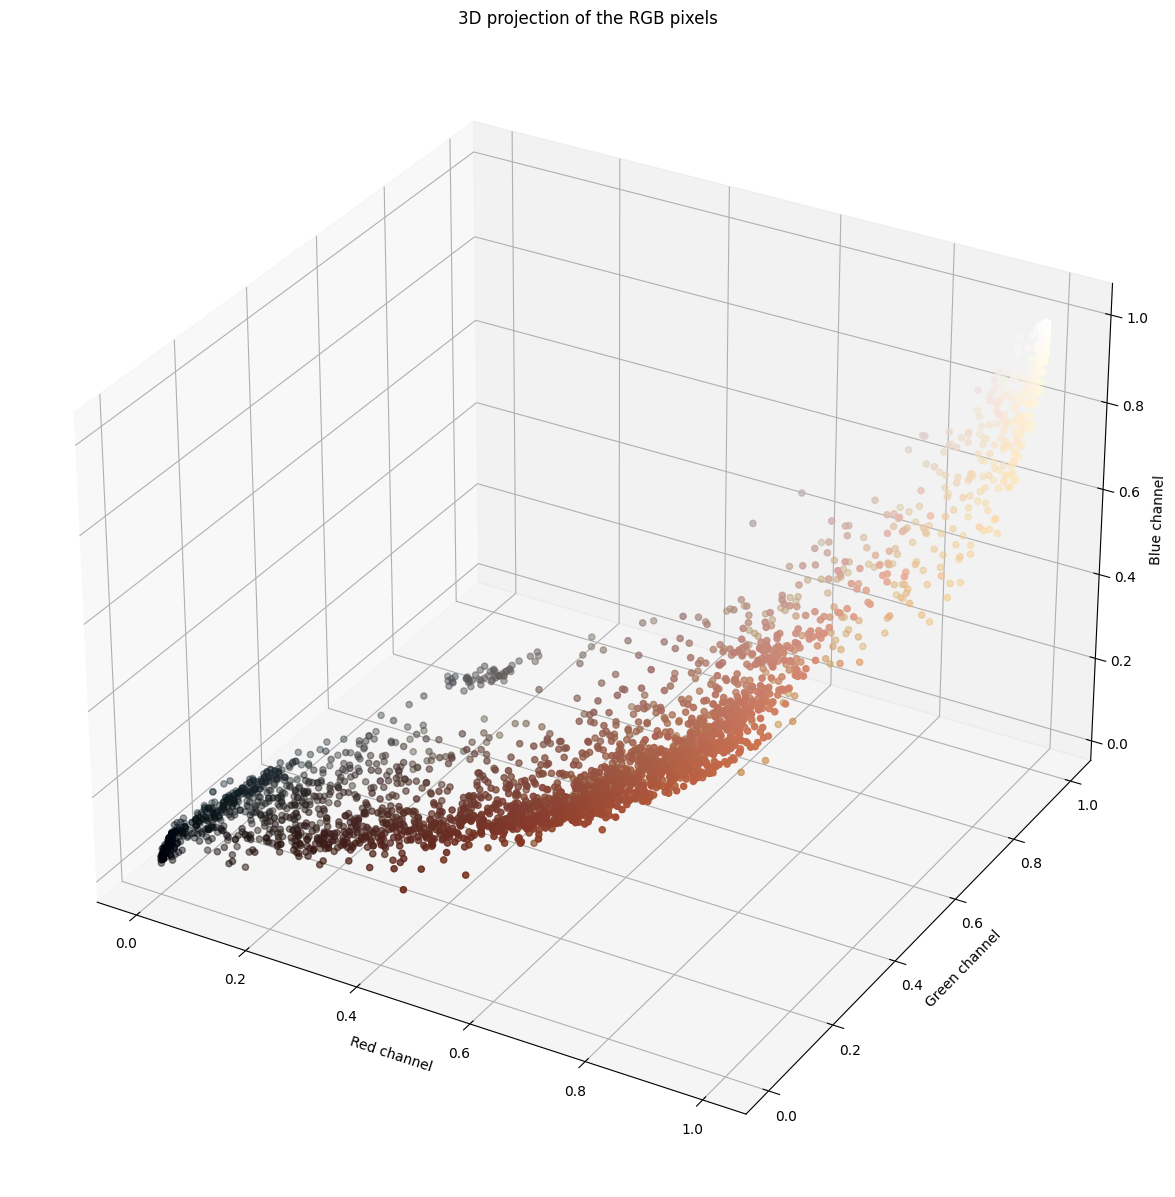

In [296]:
"""
Now that we have the image collapsed in a list of pixels, it is possible
to display each individual pixel in 3D, just by connecting the RGB intensities
to the axis X, Y, Z.
"""
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*pixels_small.T, color=pixels_small)
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.title("3D projection of the RGB pixels")
plt.show()

## Step 1: Computing distances

The first step consist of computing the euclidean distance between two sets of points which we will later use in the k-means algorithm. The eucledian distance between two points $p$ and $q$ is given by

$$d = \sqrt{(q-p)^2} $$
which for multiple dimensions extends to

$$d = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + (q_3-p_3)^2 + ...  + (q_n-p_n)^2} $$

In [297]:
def euclidean_dist(a, b):
    """Computes the euclidean distance between two sets of D-dimensional points.
    
    Args:
        a (array): A list of points of shape (N, D).
        b (array): A list of points of shape (M, D).
    
    Returns:
        (array): An array of shape (N, M) containing all the pairwise distances between each point of a and b.
    """
    # If a or b are python lists, they are transformed into numpy arrays.
    if isinstance(a, list): a = np.array(a)
    if isinstance(b, list): b = np.array(b)
    assert a.ndim == 2 and b.ndim == 2, "a and b must be 2-dimensional arrays."
    assert a.shape[1] == b.shape[1], "a and b must have the same dimension D."
    
    #N = a.shape[0]
    #M = b.shape[0]
    #D = a.shape[1]

    #RGB_diff = a[:, :, None] - b[:, :, None].T
    #squared_sum_diff = (RGB_diff**2).sum(1)
    #distances = np.sqrt(squared_sum_diff)

    distances = np.sqrt(((a[:, :, None] - b[:, :, None].T)**2).sum(1))

    
    
    return distances

In [298]:
# Testing the euclidean distance
assert euclidean_dist([[0]], [[1]]) == 1, "Unit test 1 failed."
assert euclidean_dist([[0, 0, 0]], [[1, 1, 1]]) == np.sqrt(3), "Unit test 2 failed."
np.random.seed(0)
random_array1 = np.random.rand(10, 4)
random_array2 = np.random.rand(10, 4)
assert np.abs(euclidean_dist(random_array1, random_array2).mean() - 0.8897) < 1e-4, "Unit test 3 failed."

[[0.6117647  0.34509805 0.25490198]]


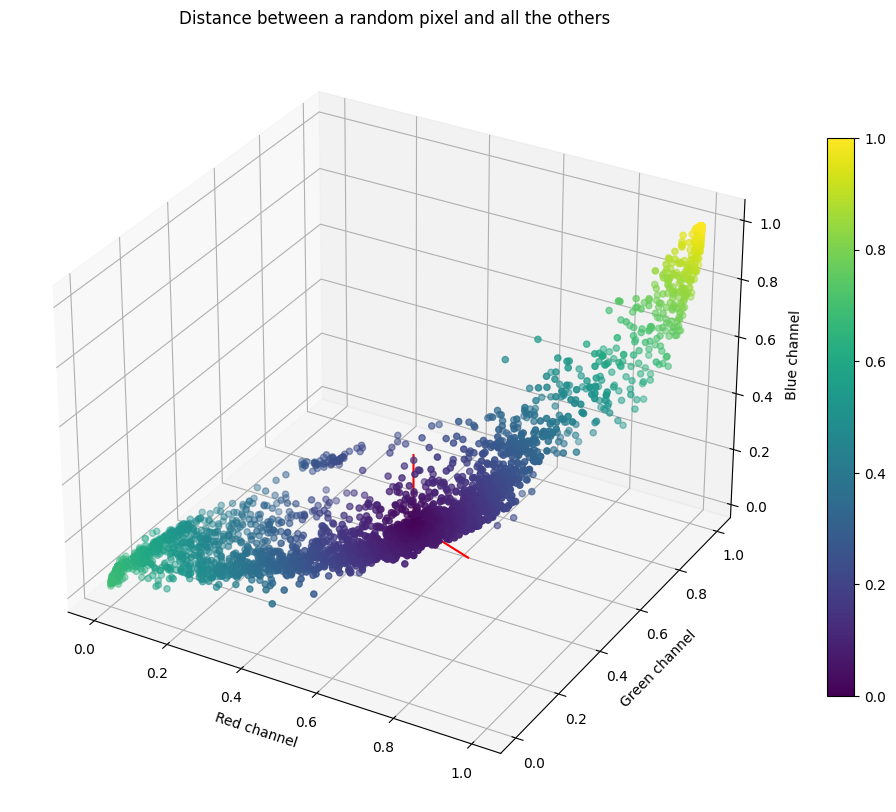

In [299]:
# We will test the euclidean function by picking a random pixel
# and checking its distance with all the other pixels in the image.
# you can choose to modify "random_pixel" to a specific pixel or
# position in the 3D space.
N = pixels_small.shape[0]
random_index = np.random.randint(N)
random_pixel = np.array([pixels_small[random_index]])
print(random_pixel)

# Computing all the distances
distances = euclidean_dist(random_pixel, pixels_small)[0]
# The distances are normalised to be between 0 and 1.
distances /= distances.max()
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(*pixels_small.T, c=distances)
fig.colorbar(p, fraction=0.03)
ax.scatter(*random_pixel.T, c=['r'], marker='2', s=[10000])
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.title("Distance between a random pixel and all the others")
plt.show()

## KMeans clustering

Now lets implement the k-means algorithm. We will construct a class that has two functions. One for fitting the data, i.e iterativly finds the optimal cluster centers and one for predicting data points into the respective clusters.

In [300]:
# The following part needs to be implemented by you.
class KMeans:
    """ K-Means Algorithm. """

    def __init__(self, K, D):
        """Initialisation of the KMeans algorithm.
        Args:
            K (int): The number of clusters to use.
            D (int): The number of dimensions
        """
        self.K = K
        self.D = D
        # Initialise the clusters to zero
        self.clusters = np.zeros((K, D))
    
    def fit(self, data, iterations=5):
        """Trains the algorithm and iteratively refines the clusters' positions.
        
        Args:
            data (array): The data points to cluster, shape must be (N, D)
            iterations (int): The number of iterations of the K-means algorithm.
        
        Note:
            The algorithm updates the member variable "clusters".
        """
        assert data.ndim == 2 and data.shape[1] == self.D, "The data should have the shape (N, D)."
        assert iterations > 0, "The number of iterations should be positive."
        # Starting the algorithm
        N = data.shape[0] # Number of points in the data

        # [CODE HERE] Update the clusters in function of the data
        # 1. Pick K random points from the data and use them as starting position for the clusters.
        self.clusters = np.random.rand(self.K, self.D)
        for _ in range(iterations):
            # 2. Compute the distances between the data and the clusters
            dists = euclidean_dist(data, self.clusters)

            # 3. Associate each data point to the nearest cluster
            belongs_to = np.argmin(dists, axis=1)

            # 4. For each cluster
            for i in range(self.K):

                # 5. Gather all the points in the cluster
                data_indices = np.where(belongs_to==i)[0]

                data_in_cluster = data[data_indices]
                
                if (len(data_in_cluster)>0):
                    mean_value = np.mean(data_in_cluster, axis=0)
                else:
                    mean_value = np.random.rand(self.D)
                    
                # 7. Update of the position of the cluster
                self.clusters[i] = mean_value


                
        # [/CODE HERE]
    
    def predict(self, data):
        """Predicts the cluster id for each of the
        
        Args:
            data (array): The data points to cluster, shape must be (N, D)
        
        Returns:
            (list of int): The id of the cluster of each of the data points, shape is N.
        """
        assert data.ndim == 2 and data.shape[1] == self.D, "The data should have the shape (N, D)."
        
        # [CODE HERE] Update the clusters in function of the data
        # 1. Compute the distances between data and the clusters.
        dists = euclidean_dist(data, self.clusters)

        # 2. The datapoints are associated to each clusters.
        clustered_points = np.argmin(dists, axis=1)

        # [/CODE HERE]

        return clustered_points

In [301]:
# Choose a number of clusters
K = 16
kmeans = KMeans(K=K, D=3)
kmeans.fit(pixels_small, iterations=30)

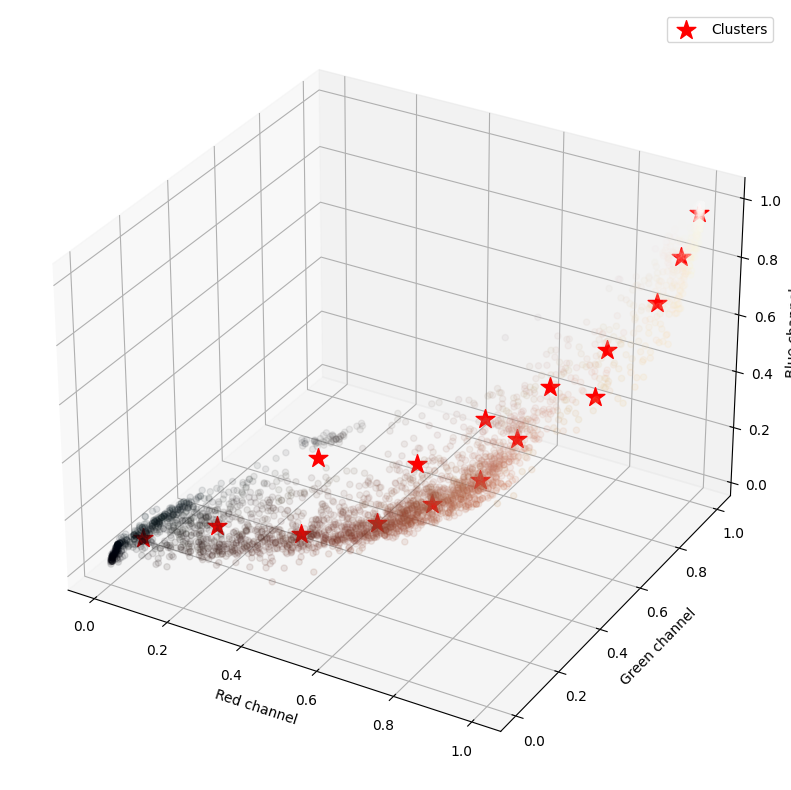

In [302]:
"""
Again, we show the 3D projection of the RGB pixels, along with the position of the learnt clusters.
"""
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*pixels_small.T, color=pixels_small, alpha=0.1)
ax.scatter(*kmeans.clusters.T, s=200, color="red", marker="*", depthshade=False, label="Clusters")
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.legend()
plt.show()

## Clustering the image

Now let's test cluster the rest of the pixels in the image and assing new colors i.e compress the image. This might take a while

In [303]:
# We take the original image (we dropped a lot of pixels in the beginning, remember?), as
# we will compress the full sized image.
# We already trained the kmeans algorithm by calling fit before.
# Each of the pixels of the big image is associated to a specific cluster.
clustered_image = kmeans.predict(pixels)

# We now need to determine which color is given to each cluster. In this case
# we will take the mean.
# Constructing the palette
palette = np.empty((kmeans.K, kmeans.D))
# For each cluster
for i in range(kmeans.K):
    # We take the pixels belonging to the ith cluster.
    cluster = pixels[clustered_image == i]
    # We compute the average color for the cluster
    color = cluster.mean(axis=0)
    # The ith color of the palette is set.
    palette[i] = color

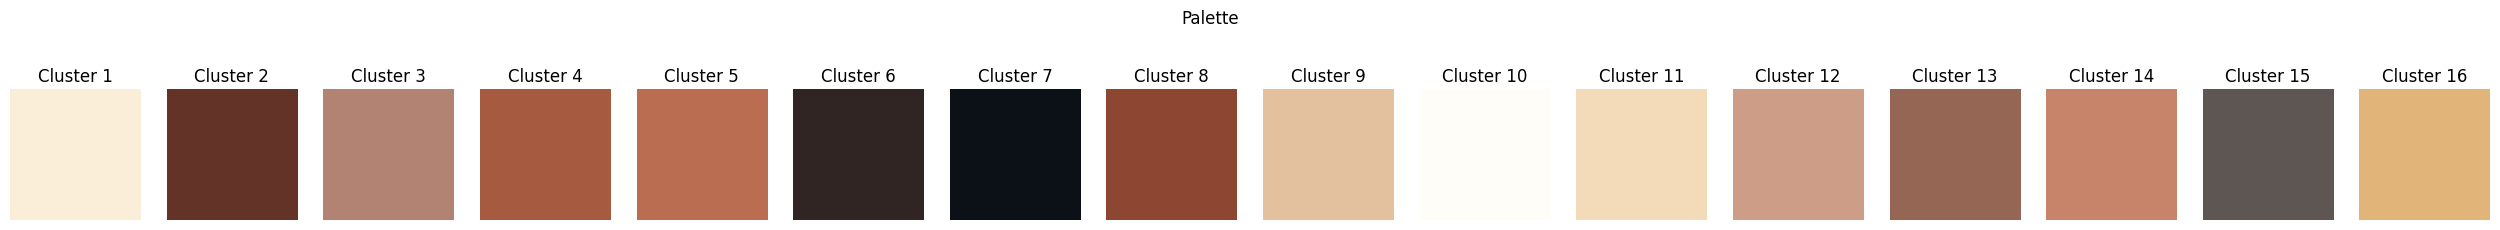

In [304]:
fig, ax = plt.subplots(1, kmeans.K, figsize=(2*kmeans.K, 3))
fig.suptitle("Palette")
for i in range(kmeans.K):
    ax[i].set_title(f"Cluster {i+1}")
    ax[i].imshow(palette[i].reshape(1, 1, kmeans.D), interpolation="None")
    ax[i].axis("off")
plt.show()

In [305]:
def cluster2image(image, palette, imshape):
    """Constructs an RGB image from the clustered pixels and a palette.
    
    Args:
        image (list of int): a list of clustered pixels, shape (N).
        palette (array): a list of K different colors.
        imshape: the 2D shape of the image to create.
    """
    assert image.ndim == 1, "The image must have only one dimension."
    assert palette.ndim == 2, "The palette must have two dimensions."
    assert isinstance(imshape, tuple), "imshape must be a tuple."

    N = image.shape[0]
    K, D = palette.shape

    final_image = np.empty((N, D))
    for i in range(K):
        cluster = image == i
        for j in range(D):
            final_image[cluster, j] = palette[i, j]
    
    return final_image.reshape(imshape)

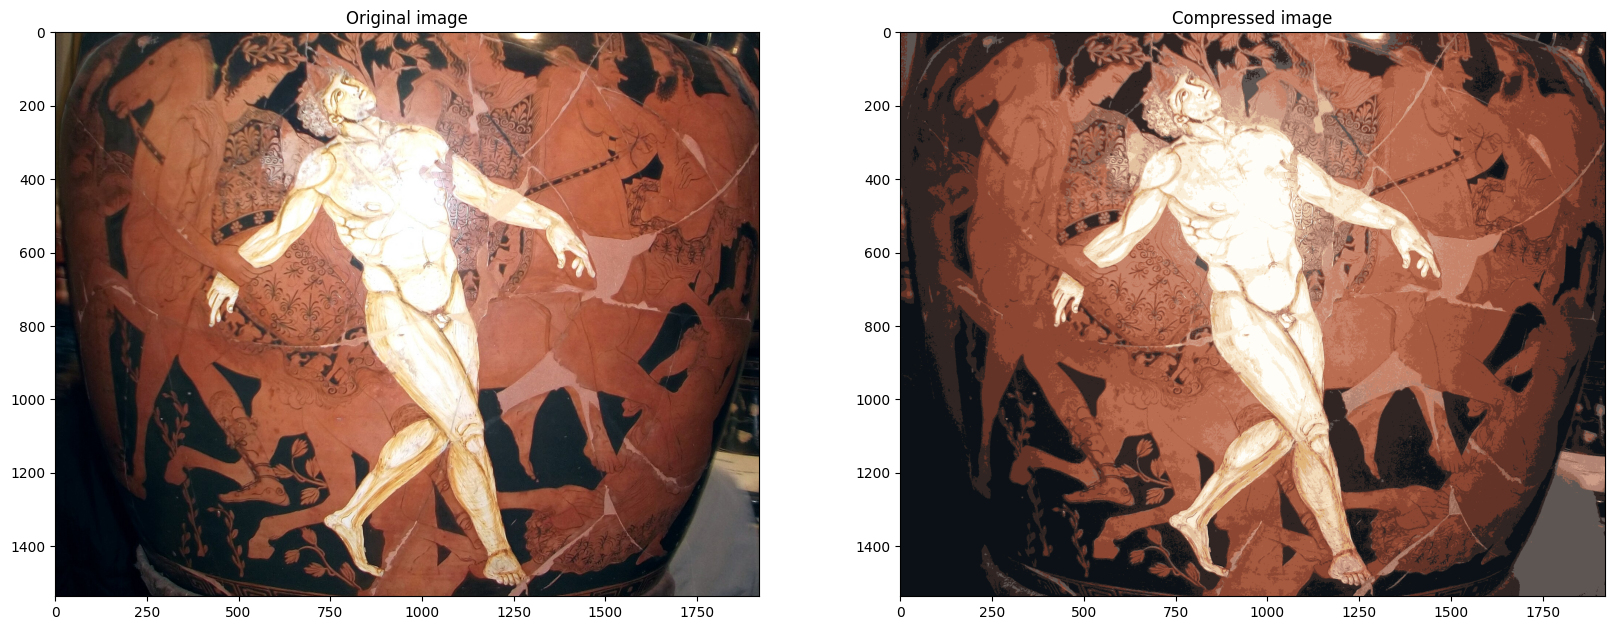

In [306]:
final_image = cluster2image(clustered_image, palette, image.shape)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Original image")
ax[0].imshow(image)
ax[1].set_title("Compressed image")
ax[1].imshow(final_image)
plt.show()